# Reinforcement Learning for Portfolio Optimization: Model Development and Evaluation


This notebook is a critical part of the thesis, focusing on the application of reinforcement learning (RL) for optimizing financial portfolios. It encompasses several key phases of the research:

- Construction of the Stock trading enviornment
- The Training an testing RL agents
- Evaluation of different RL models against benchmark portfolio strategies
- Optimization and hyperparameter tunning 
- Evalutation of PCA on performance



In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install gymnasium
!pip install stable-baselines3


In [2]:
from __future__ import annotations

from typing import List

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, TD3, DDPG, SAC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns
import torch  
random.seed(42) 
%matplotlib inline


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Download data from Data retrival and processing

In [3]:
train_p_df = pd.read_csv('/kaggle/input/tfmdata/train_p_df.csv')
test_p_df = pd.read_csv('/kaggle/input/tfmdata/test_p_df.csv')

train_p_df = train_p_df.set_index('Unnamed: 0')
train_p_df.index.name = None


test_p_df = test_p_df.set_index('Unnamed: 0')
test_p_df.index.name = None


In [4]:
test_p_df

,date,tic,open,high,low,close,volume,daily gain,turbulence,ma50,...,count articles,sentiment value,close-ma50,close-ma20,close-ema20,close-ema50,close-upperbb,close-middlebb,close-lowerbb,day
0,2022-07-21,AAPL,4326.004326,4355.964356,4254.324254,4349.80435,65086636.0,0.015094,0.016446,143.2272,...,31.0,0.4238,4206.57715,4205.14935,4203.022988,4203.022988,4189.69595,4207.80335,4225.91075,3
0,2022-07-21,ADBE,404.120000,409.650000,399.240100,408.91000,2009914.0,0.018481,0.021054,392.3512,...,2.0,0.0810,16.55880,28.32650,14.781389,14.781389,-47.87950,16.55880,80.99710,3
0,2022-07-21,AMZN,2464.000000,2497.000000,2425.200000,2492.60000,60239892.0,0.015150,0.027033,878.8266,...,51.0,0.4981,1613.77340,2379.15850,1694.827961,1694.827961,2361.77400,2380.16820,2398.56250,3
0,2022-07-21,BA,158.890000,161.655000,156.190000,161.41000,8044091.0,0.019131,0.028062,135.4652,...,14.0,0.4437,25.94480,18.03000,16.629589,16.629589,-2.89670,25.94480,54.78630,3
0,2022-07-21,BRK.B,287.000000,287.240000,282.090000,286.85000,3700275.0,0.002832,0.013671,291.8134,...,0.0,0.0000,-4.96340,9.23150,-4.530855,-4.530855,-56.75290,-4.96340,46.82610,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,2024-01-02,PCG,17.880000,18.140000,17.830000,18.05000,14115636.0,0.001109,0.012407,17.2128,...,0.0,0.0000,0.83720,0.39750,0.697715,0.697715,-1.19300,0.84610,2.88530,1
364,2024-01-02,PFE,30.439520,31.913855,30.386820,31.33542,57948706.0,0.032650,0.022545,29.4664,...,3.0,0.7103,1.86902,3.08042,1.690088,1.690088,-1.40818,1.98632,5.38092,1
364,2024-01-02,TSLA,3751.200000,3768.750000,3666.150000,3726.30000,104654163.0,-0.000241,0.021011,233.4620,...,42.0,0.4236,3492.83800,3478.68250,3483.576531,3483.576531,3443.06350,3492.83800,3542.61250,1
364,2024-01-02,WM,177.720000,180.710000,177.670000,179.61000,1299038.0,0.002848,0.008667,171.0918,...,0.0,0.0000,8.51820,3.45750,7.883094,7.883094,-9.52150,8.90040,27.32230,1


## Stock trading environment from FinRL

In [5]:

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state
    #TODO Delete above
    def render(self, mode="human", close=False):
        # Example of rendering the current state
        if mode == "human":
            print(f"Current Day: {self.day}")
            print(f"Current Portfolio Value: {self.state[0]}")
            print(f"Current Positions: {self.state[(self.stock_dim + 1):(self.stock_dim * 2 + 1)]}")
            # Add any additional information you want to display


    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

### Configuration & implementation

In [6]:
INDICATORS = [
    'volume',
    'turbulence',
    'ma50',
    'ma20',
    'ema20',
    'ema50',
    'daily gain',
    'volume change',
    'rsi',
    'real upper band',
    'real middle band',
    'real lower band',
    'macd',
    'macd_signal',
    'macd_hist',
    'slowk',
    'slowd', 
    'aroon down', 
    'aroon up',
    'obv', 
    'adx', 
    'chaikin a/d', 
    'cci', 
    'sp500_delta', 
    'count articles',
    'sentiment value',
    'close-ma50',
    'close-ma20',
    'close-ema20',
    'close-ema50',
    'close-upperbb',
    'close-middlebb',
    'close-lowerbb',
    'day',
]
  

stock_dimension = len(train_p_df.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
  
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train_p_df, **env_kwargs)


Stock Dimension: 19, State Space: 685


In [7]:
env_train, test_obs = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## Evaluation of different RL models against benchmark portfolio strategies

Testing different algorithms from the Stable Baselines library for portfolio performance against an evenly balanced portfolio and a Markowitz portfolio model.


In [8]:
def train_model_and_evaluate(model_class, policy, train_df, env_kwargs, total_timesteps):
    """
    This function creates a model, trains it on the provided DataFrame, and evaluates on the same data.
    
    Args:
    - model_class: Class from stable_baselines3 (e.g., A2C, PPO, etc.).
    - policy: Policy model to use (e.g., 'MlpPolicy').
    - train_df: Training DataFrame.
    - env_kwargs: A dictionary of environment keyword arguments.
    - total_timesteps: Total timesteps for the model to learn.

    Returns:
    - The trained model.
    - A DataFrame with the account memory (portfolio value over time) for the training set.
    - A DataFrame with the actions memory (actions taken over time) for the training set.
    """
    # Create the training environment
    train_env = DummyVecEnv([lambda: StockTradingEnv(df=train_df, **env_kwargs)])
    
    # Create the model
    model = model_class(policy, train_env, verbose=1)
    
    # Train the model
    model.learn(total_timesteps=total_timesteps)

    # Evaluate the model on the training set
    train_env.reset()
    max_steps = len(train_df.index.unique()) - 1
    account_memory = []
    actions_memory = []

    # Run the trained model on the training environment
    train_obs = train_env.reset()
    for i in range(max_steps):
        action, _states = model.predict(train_obs, deterministic=True)
        train_obs, rewards, dones, info = train_env.step(action)
        if i == max_steps - 1 or dones[0]:
            account_memory = train_env.env_method(method_name="save_asset_memory")[0]
            actions_memory = train_env.env_method(method_name="save_action_memory")[0]
            break

    # Convert memories to DataFrames
    return model, pd.DataFrame(account_memory), pd.DataFrame(actions_memory)



In [9]:
def evaluate_model(model, test_df, env_kwargs):
    """
    This function evaluates a trained model on the provided test DataFrame.
    
    Args:
    - model: The trained model from stable_baselines3.
    - test_df: Test DataFrame.
    - env_kwargs: A dictionary of environment keyword arguments.

    Returns:
    - A tuple of DataFrames: (account memory, action memory)
    """
    # Create the test environment
    test_env = DummyVecEnv([lambda: StockTradingEnv(df=test_df, **env_kwargs)])
    test_env.reset()
    
    max_steps = len(test_df.index.unique()) - 1
    # Initialize memory stores
    account_memory = []
    actions_memory = []

    # Evaluate the model
    test_obs = test_env.reset()
    for i in range(max_steps):
        action, _states = model.predict(test_obs, deterministic=True)
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps - 1 or dones[0]:
            account_memory = test_env.env_method(method_name="save_asset_memory")[0]
            actions_memory = test_env.env_method(method_name="save_action_memory")[0]

            break


    # Convert memories to DataFrames
    account_memory_df = pd.DataFrame(account_memory)
    actions_memory_df = pd.DataFrame(actions_memory)

    return account_memory_df, actions_memory_df



In [10]:
total_timesteps = 50000

In [11]:
# Train the model and get the training performance data
model, PPO_results, PPO_train_actions = train_model_and_evaluate(
    PPO, "MlpPolicy", train_p_df, env_kwargs, total_timesteps
)
# Evaluate the trained model with test data
PPO_test, PPO_test_actions = evaluate_model(model, test_p_df, env_kwargs)


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 107  |
|    iterations      | 1    |
|    time_elapsed    | 19   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 2           |
|    time_elapsed         | 39          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007918513 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.9       |
|    explained_variance   | -0.0011     |
|    learning_rate        | 0.0003      |
|    loss                 | 42.5        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00572    |
|    std                  | 0.997       |
|    value_loss           | 79.2        |
----------------

In [12]:
# Train and evaluate A2C
a2c_model, A2C_results, A2C_train_actions = train_model_and_evaluate(
    A2C, "MlpPolicy", train_p_df, env_kwargs, total_timesteps
)
A2C_test, A2C_test_actions = evaluate_model(a2c_model, test_p_df, env_kwargs)



Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 101      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -26.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 34.3     |
|    std                | 0.994    |
|    value_loss         | 2.63     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 101      |
|    iterations         | 200      |
|    time_elapsed       | 9        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -26.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss    

In [13]:
# Train and evaluate TD3
td3_model, TD3_results, TD3_train_actions = train_model_and_evaluate(
    TD3, "MlpPolicy", train_p_df, env_kwargs, total_timesteps
)
TD3_test, TD3_test_actions = evaluate_model(td3_model, test_p_df, env_kwargs)


Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 80       |
|    time_elapsed    | 106      |
|    total_timesteps | 8600     |
| train/             |          |
|    actor_loss      | 2.38e+08 |
|    critic_loss     | 1.4e+14  |
|    learning_rate   | 0.001    |
|    n_updates       | 6450     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 76       |
|    time_elapsed    | 224      |
|    total_timesteps | 17200    |
| train/             |          |
|    actor_loss      | 2.01e+08 |
|    critic_loss     | 5.39e+13 |
|    learning_rate   | 0.001    |
|    n_updates       | 15050    |
---------------------------------
day: 2149, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 6859488.52
total_reward: 5859488.52
total_cost: 999.00
total_trades: 30086
Sharpe: 1.028
-------

In [14]:
# Train and evaluate DDPG
ddpg_model, DDPG_results, DDPG_train_actions = train_model_and_evaluate(
    DDPG, "MlpPolicy", train_p_df, env_kwargs, total_timesteps
)
DDPG_test, DDPG_test_actions = evaluate_model(ddpg_model, test_p_df, env_kwargs)



Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 78        |
|    time_elapsed    | 109       |
|    total_timesteps | 8600      |
| train/             |           |
|    actor_loss      | -1.58e+08 |
|    critic_loss     | 5.8e+13   |
|    learning_rate   | 0.001     |
|    n_updates       | 6450      |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 74        |
|    time_elapsed    | 232       |
|    total_timesteps | 17200     |
| train/             |           |
|    actor_loss      | -1.09e+08 |
|    critic_loss     | 4.47e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 15050     |
----------------------------------
day: 2149, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 6014167.41
total_reward: 5014167.41
total_cost: 998.99
total_trades: 177

In [15]:
# Train and evaluate SAC
sac_model, SAC_results, SAC_train_actions = train_model_and_evaluate(
    SAC, "MlpPolicy", train_p_df, env_kwargs, total_timesteps
)
SAC_test, SAC_test_actions = evaluate_model(sac_model, test_p_df, env_kwargs)


Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 48       |
|    time_elapsed    | 177      |
|    total_timesteps | 8600     |
| train/             |          |
|    actor_loss      | 3.23e+08 |
|    critic_loss     | 3.13e+12 |
|    ent_coef        | 12.9     |
|    ent_coef_loss   | -953     |
|    learning_rate   | 0.0003   |
|    n_updates       | 8499     |
---------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 49        |
|    time_elapsed    | 348       |
|    total_timesteps | 17200     |
| train/             |           |
|    actor_loss      | 2.21e+08  |
|    critic_loss     | 2.7e+12   |
|    ent_coef        | 170       |
|    ent_coef_loss   | -1.92e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 17099     |
----------------------------------
day: 2149, episo

### Caluclate Balanced and Markowitz Portfolios

In [16]:
import pandas as pd
initial_investment = 1000000 

def calculate_portfolio_balance(df):
    unique_stocks = df['tic'].unique()
    investment_per_stock = initial_investment / len(unique_stocks)
    
    first_date = df['date'].min()
    initial_prices = df[df['date'] == first_date]

    initial_quantities = {tic: investment_per_stock / initial_prices[initial_prices['tic'] == tic]['close'].values[0] 
                          for tic in unique_stocks}

    portfolio_balance = pd.DataFrame(columns=['date', 'balanced_portfolio'])

    for date in df['date'].unique():
        daily_data = df[df['date'] == date]
        daily_portfolio_value = 0
        for tic in daily_data['tic'].unique():
            daily_stock_price = daily_data[daily_data['tic'] == tic]['close'].iloc[0]
            daily_portfolio_value += daily_stock_price * initial_quantities[tic]
        new_row = pd.DataFrame({'date': [date], 'balanced_portfolio': [daily_portfolio_value]})
        portfolio_balance = pd.concat([portfolio_balance, new_row], ignore_index=True)

    portfolio_balance['date'] = pd.to_datetime(portfolio_balance['date'])
    portfolio_balance.sort_values('date', inplace=True)

    return portfolio_balance


# Calculating portfolio balance for training data
portfolio_balance_train = calculate_portfolio_balance(train_p_df)

# Calculating portfolio balance for testing data
portfolio_balance_test = calculate_portfolio_balance(test_p_df)

# Display the results
print("Training Portfolio Balance:\n", portfolio_balance_train.head())
print("\nTesting Portfolio Balance:\n", portfolio_balance_test.head())


/tmp/ipykernel_42/443966749.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  portfolio_balance = pd.concat([portfolio_balance, new_row], ignore_index=True)
/tmp/ipykernel_42/443966749.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  portfolio_balance = pd.concat([portfolio_balance, new_row], ignore_index=True)


Training Portfolio Balance:
         date  balanced_portfolio
0 2014-01-06        1.000000e+06
1 2014-01-07        1.006214e+06
2 2014-01-08        1.005090e+06
3 2014-01-09        1.003852e+06
4 2014-01-10        1.003612e+06

Testing Portfolio Balance:
         date  balanced_portfolio
0 2022-07-21      1000000.000000
1 2022-07-22       992800.073622
2 2022-07-25       990784.477158
3 2022-07-26       972380.757786
4 2022-07-27       997894.154964


In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def calculate_markowitz_portfolio(df):
    unique_stocks = df['tic'].unique()
    
    # Calculate expected returns and covariance matrix
    expected_returns = df.groupby('tic')['daily gain'].mean()
    cov_matrix = df.pivot(index='date', columns='tic', values='daily gain').cov()

    # Number of assets
    num_assets = len(unique_stocks)

    # Optimization constraints and bounds
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # sum of weights is 1
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Function to minimize (negative Sharpe Ratio)
    def min_sharpe_ratio(weights):
        portfolio_return = np.sum(expected_returns * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_volatility

    # Initial guess (equal distribution)
    init_guess = num_assets * [1. / num_assets]

    # Optimization
    opt_results = minimize(min_sharpe_ratio, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    # Optimal weights
    optimal_weights = opt_results.x

    # Calculating portfolio balance using optimal weights
    initial_investment = 1000000 
    initial_quantities = {tic: (initial_investment * weight) / df[df['tic'] == tic]['close'].iloc[0] 
                          for tic, weight in zip(unique_stocks, optimal_weights)}

    portfolio_balance = pd.DataFrame(columns=['date', 'portfolio_value'])
    for date in df['date'].unique():
        daily_data = df[df['date'] == date]
        daily_portfolio_value = sum(daily_data[daily_data['tic'] == tic]['close'].iloc[0] * quantity
                                    for tic, quantity in initial_quantities.items())
        new_row = pd.DataFrame({'date': [date], 'portfolio_value': [daily_portfolio_value]})
        portfolio_balance = pd.concat([portfolio_balance, new_row], ignore_index=True)


    return portfolio_balance

# Calculate Markowitz portfolio balance for training and testing data
markowitz_balance_train = calculate_markowitz_portfolio(train_p_df)
markowitz_balance_test = calculate_markowitz_portfolio(test_p_df)



/tmp/ipykernel_42/2807942833.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  portfolio_balance = pd.concat([portfolio_balance, new_row], ignore_index=True)
/tmp/ipykernel_42/2807942833.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  portfolio_balance = pd.concat([portfolio_balance, new_row], ignore_index=True)


### Compare Portfolio performance

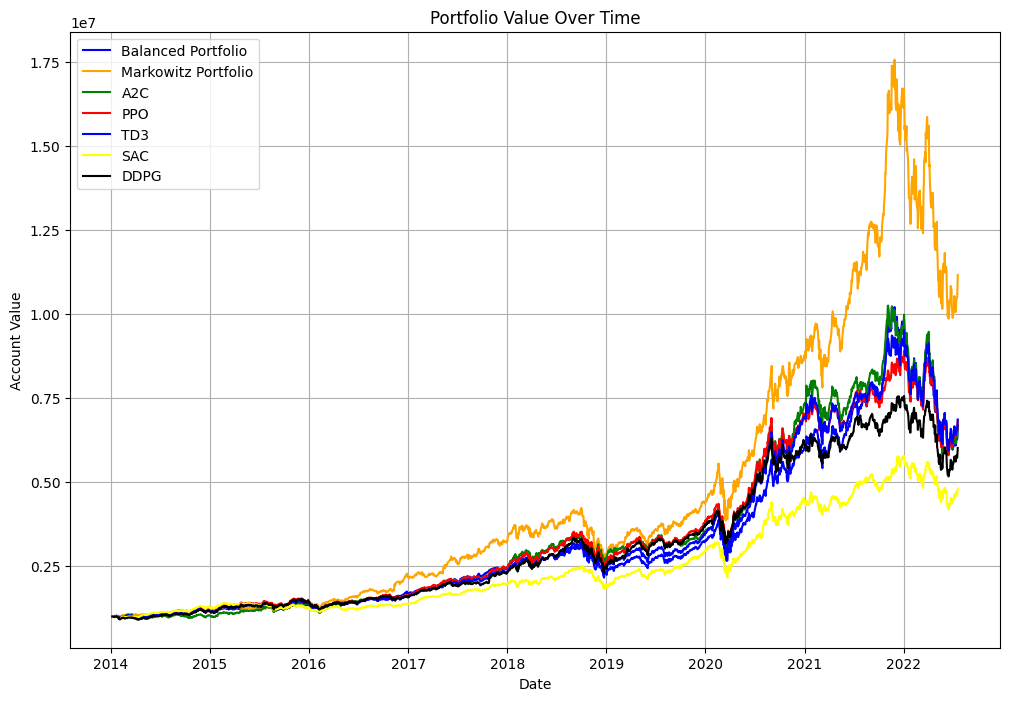

In [18]:
trainning_results = portfolio_balance_train
trainning_results['markowitz']=markowitz_balance_train['portfolio_value']
trainning_results['A2C']=A2C_results['account_value']
trainning_results['PPO']=PPO_results['account_value']    
trainning_results['SAC']=SAC_results['account_value']    
trainning_results['TD3']=TD3_results['account_value']    
trainning_results['DDPG']=DDPG_results['account_value']    


# Plotting
plt.figure(figsize=(12, 8))
plt.plot(trainning_results['date'], trainning_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(trainning_results['date'], trainning_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(trainning_results['date'], trainning_results['A2C'], label='A2C', color='green')
plt.plot(trainning_results['date'], trainning_results['PPO'], label='PPO', color='red')
plt.plot(trainning_results['date'], trainning_results['TD3'], label='TD3', color='blue')
plt.plot(trainning_results['date'], trainning_results['SAC'], label='SAC', color='yellow')
plt.plot(trainning_results['date'], trainning_results['DDPG'], label='DDPG', color='black')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()


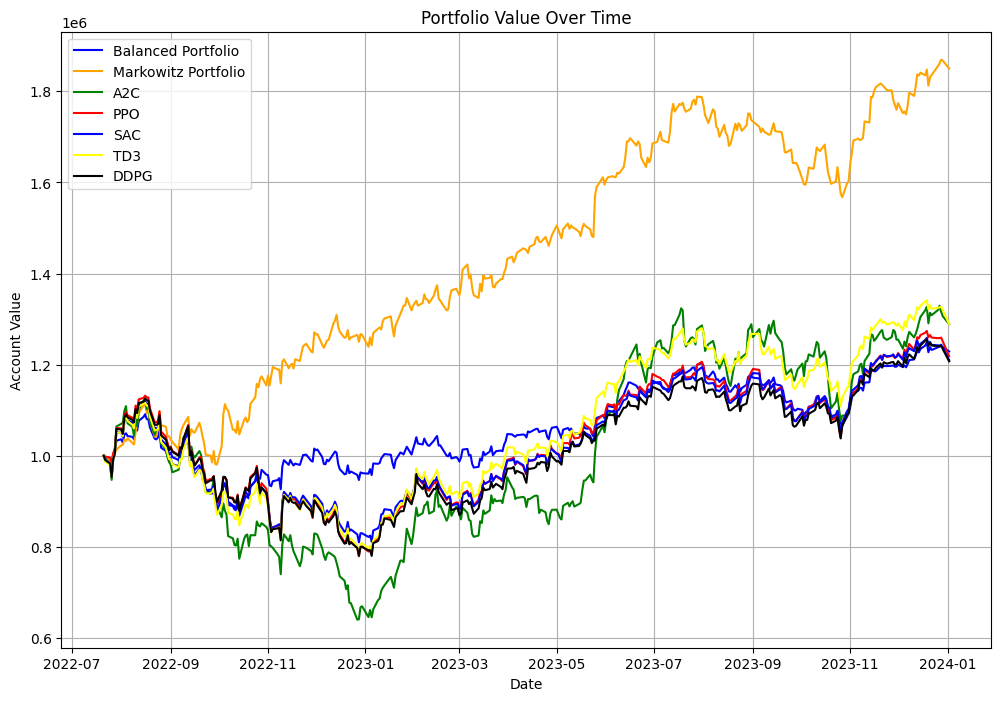

In [19]:
test_results = portfolio_balance_test
test_results['markowitz']=markowitz_balance_test['portfolio_value']
test_results['A2C']=A2C_test['account_value']
test_results['PPO']=PPO_test['account_value']    
test_results['SAC']=SAC_test['account_value']    
test_results['TD3']=TD3_test['account_value']    
test_results['DDPG']=DDPG_test['account_value']    



# Plotting
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], test_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(test_results['date'], test_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(test_results['date'], test_results['A2C'], label='A2C', color='green')
plt.plot(test_results['date'], test_results['PPO'], label='PPO', color='red')
plt.plot(test_results['date'], test_results['SAC'], label='SAC', color='blue')
plt.plot(test_results['date'], test_results['TD3'], label='TD3', color='yellow')
plt.plot(test_results['date'], test_results['DDPG'], label='DDPG', color='black')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()


### Compare Sharpe Ratio

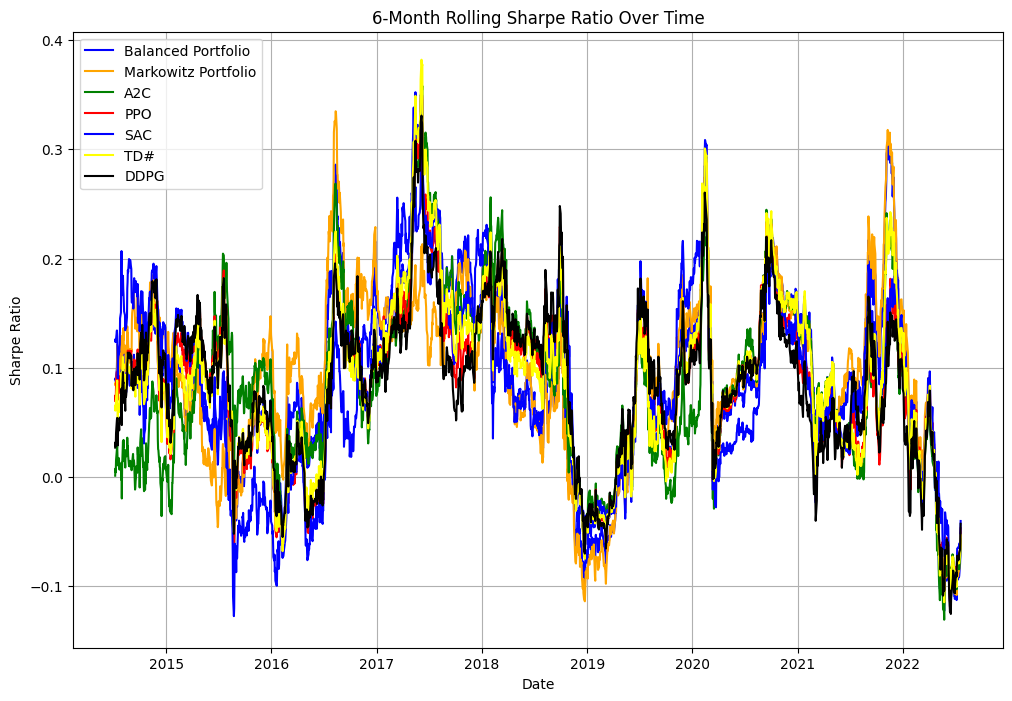

In [20]:

import pandas as pd
import matplotlib.pyplot as plt

def calculate_sharpe(column_data):
    # Calculate daily returns
    daily_return = column_data.pct_change()

    # Convert annual risk-free rate to daily (assuming 252 trading days in a year)
    daily_risk_free_rate = (1 + 0.01) ** (1/252) - 1

    # Calculate excess returns
    excess_return = daily_return - daily_risk_free_rate

    # Calculate rolling mean and standard deviation of excess returns (6 months window)
    rolling_window = 126  # Approx. 6 months
    rolling_mean_return = excess_return.rolling(window=rolling_window).mean()
    rolling_std_return = daily_return.rolling(window=rolling_window).std()

    # Calculate Sharpe Ratio
    sharpe_ratio = rolling_mean_return / rolling_std_return

    return sharpe_ratio

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['balanced_portfolio']), label='Balanced Portfolio', color='blue')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['markowitz']), label='Markowitz Portfolio', color='orange')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['A2C']), label='A2C', color='green')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['PPO']), label='PPO', color='red')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['SAC']), label='SAC', color='blue')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['TD3']), label='TD#', color='yellow')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['DDPG']), label='DDPG', color='black')

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('6-Month Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)
plt.show()


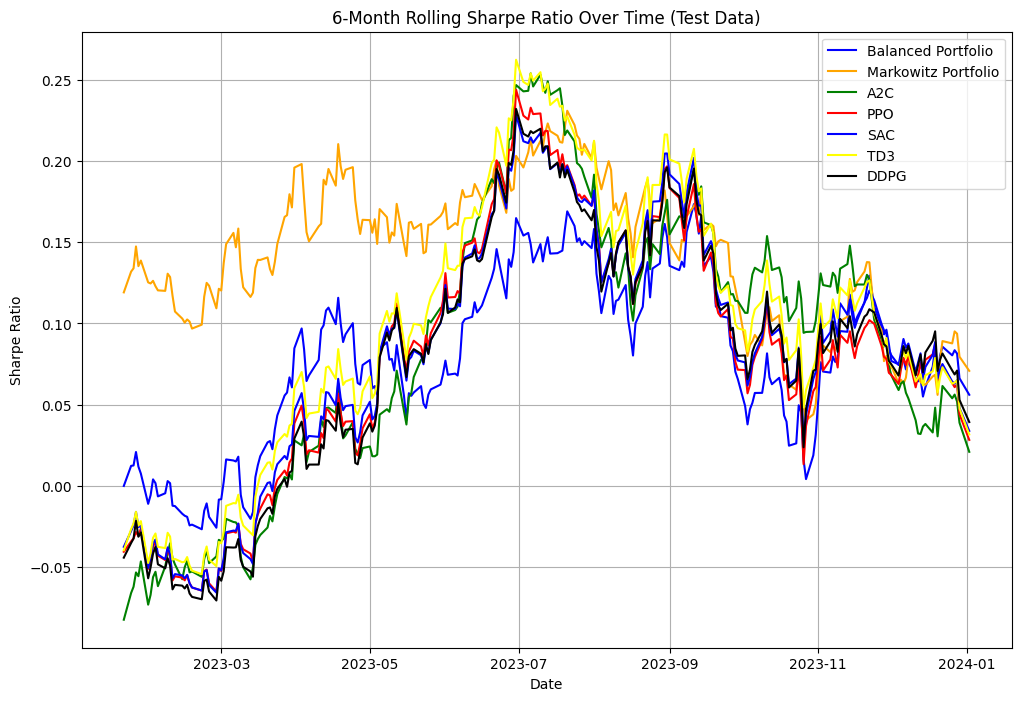

In [21]:
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], calculate_sharpe(test_results['balanced_portfolio']), label='Balanced Portfolio', color='blue')
plt.plot(test_results['date'], calculate_sharpe(test_results['markowitz']), label='Markowitz Portfolio', color='orange')
plt.plot(test_results['date'], calculate_sharpe(test_results['A2C']), label='A2C', color='green')
plt.plot(test_results['date'], calculate_sharpe(test_results['PPO']), label='PPO', color='red')
plt.plot(test_results['date'], calculate_sharpe(test_results['SAC']), label='SAC', color='blue')
plt.plot(test_results['date'], calculate_sharpe(test_results['TD3']), label='TD3', color='yellow')
plt.plot(test_results['date'], calculate_sharpe(test_results['DDPG']), label='DDPG', color='black')

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('6-Month Rolling Sharpe Ratio Over Time (Test Data)')
plt.legend()
plt.grid(True)
plt.show()


# Optimization and hyperparameter tunning 

## Evaluating different policy architectures

In [24]:
def run_model_w_arg_and_evaluate(model_class, policy, train_df, env_kwargs, policy_kwargs, total_timesteps, learning_rate):
    """
    This function creates a model with specified policy arguments, trains it on the provided DataFrame, 
    and evaluates on the same data.
    
    Args:
    - model_class: Class from stable_baselines3 (e.g., A2C, PPO, etc.).
    - policy: Policy model to use (e.g., 'MlpPolicy').
    - train_df: Training DataFrame.
    - env_kwargs: A dictionary of environment keyword arguments.
    - policy_kwargs: A dictionary of policy keyword arguments for neural network architecture.
    - total_timesteps: Total timesteps for the model to learn.

    Returns:
    - The trained model.
    - A DataFrame with the account memory (portfolio value over time) for the training set.
    - A DataFrame with the actions memory (actions taken over time) for the training set.
    """
    # Create the training environment
    train_env = DummyVecEnv([lambda: StockTradingEnv(df=train_df, **env_kwargs)])
    
    # Create the model with policy_kwargs
    model = model_class(policy, train_env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=learning_rate)
    
    # Train the model
    model.learn(total_timesteps=total_timesteps)

    # Evaluate the model on the training set
    train_env.reset()
    max_steps = len(train_df.index.unique()) - 1
    account_memory = []
    actions_memory = []

    # Run the trained model on the training environment
    train_obs = train_env.reset()
    for i in range(max_steps):
        action, _states = model.predict(train_obs, deterministic=True)
        train_obs, rewards, dones, info = train_env.step(action)
        if i == max_steps - 1 or dones[0]:
            account_memory = train_env.env_method(method_name="save_asset_memory")[0]
            actions_memory = train_env.env_method(method_name="save_action_memory")[0]
            break

    # Convert memories to DataFrames
    return model, pd.DataFrame(account_memory), pd.DataFrame(actions_memory)


In [25]:
def evaluate_model(model, test_df, env_kwargs):
    """
    This function evaluates a trained model on the provided test DataFrame.
    
    Args:
    - model: The trained model from stable_baselines3.
    - test_df: Test DataFrame.
    - env_kwargs: A dictionary of environment keyword arguments.

    Returns:
    - A tuple of DataFrames: (account memory, action memory)
    """
    # Create the test environment
    test_env = DummyVecEnv([lambda: StockTradingEnv(df=test_df, **env_kwargs)])
    test_env.reset()
    
    max_steps = len(test_df.index.unique()) - 1
    # Initialize memory stores
    account_memory = []
    actions_memory = []

    # Evaluate the model
    test_obs = test_env.reset()
    for i in range(max_steps):
        action, _states = model.predict(test_obs, deterministic=True)
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps - 1 or dones[0]:
            account_memory = test_env.env_method(method_name="save_asset_memory")[0]
            actions_memory = test_env.env_method(method_name="save_action_memory")[0]

            break


    # Convert memories to DataFrames
    account_memory_df = pd.DataFrame(account_memory)
    actions_memory_df = pd.DataFrame(actions_memory)

    return account_memory_df, actions_memory_df

In [35]:
total_timesteps = 50000
#256
policy_kwargs = dict(
    net_arch=[256, 256],  
    activation_fn=torch.nn.ReLU  
)
TD3256_model, TD3256_results, TD3256_train_actions = run_model_w_arg_and_evaluate(
    TD3, "MlpPolicy", train_p_df, env_kwargs, policy_kwargs, total_timesteps, 0.005
)
TD3256_test, TD3256_test_actions = evaluate_model(TD3256_model, test_p_df, env_kwargs)

# 64
policy_kwargs = dict(
    net_arch=[64, 64],
    activation_fn=torch.nn.Tanh 
)
TD364_model, TD364_results, TD364_train_actions = run_model_w_arg_and_evaluate(
    TD3, "MlpPolicy", train_p_df, env_kwargs, policy_kwargs, total_timesteps, 0.005
)
TD364_test, TD364_test_actions = evaluate_model(TD364_model, test_p_df, env_kwargs)



Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 79       |
|    time_elapsed    | 108      |
|    total_timesteps | 8600     |
| train/             |          |
|    actor_loss      | 1.88e+08 |
|    critic_loss     | 6.62e+13 |
|    learning_rate   | 0.005    |
|    n_updates       | 6450     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 75       |
|    time_elapsed    | 227      |
|    total_timesteps | 17200    |
| train/             |          |
|    actor_loss      | 1.92e+08 |
|    critic_loss     | 3.8e+13  |
|    learning_rate   | 0.005    |
|    n_updates       | 15050    |
---------------------------------
day: 2149, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3433931.08
total_reward: 2433931.08
total_cost: 2737.24
total_trades: 15982
Sharpe: 0.727
------

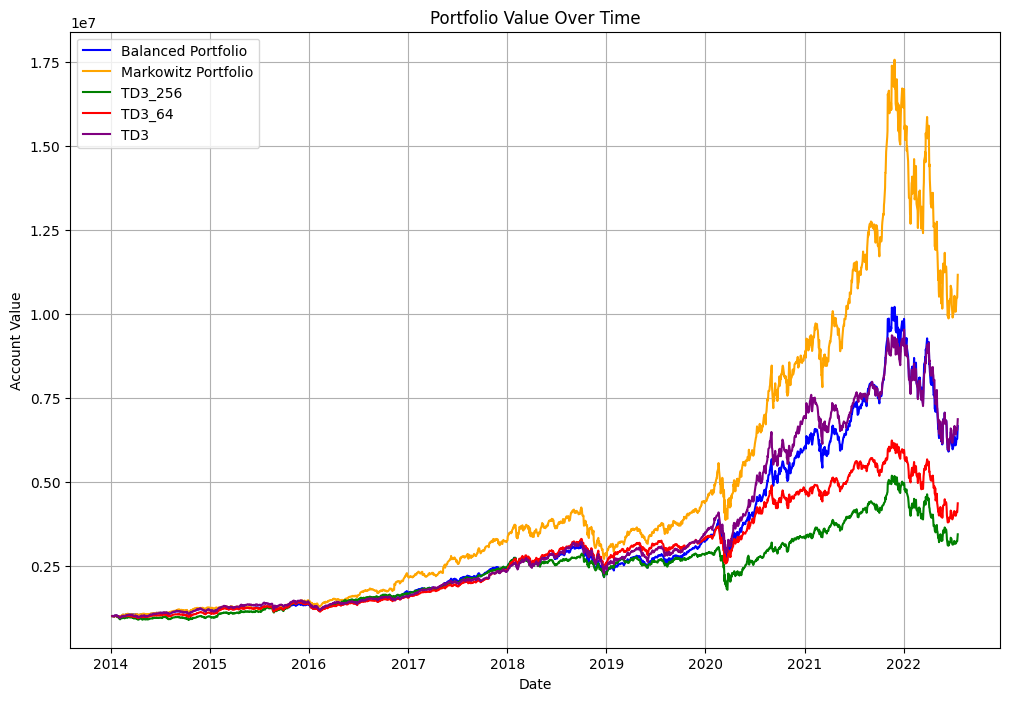

In [36]:
trainning_results = portfolio_balance_train
trainning_results['markowitz']=markowitz_balance_train['portfolio_value']
trainning_results['TD3256']=TD3256_results['account_value']
trainning_results['TD364']=TD364_results['account_value']    


# Plotting
plt.figure(figsize=(12, 8))
plt.plot(trainning_results['date'], trainning_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(trainning_results['date'], trainning_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(trainning_results['date'], trainning_results['TD3256'], label='TD3_256', color='green')
plt.plot(trainning_results['date'], trainning_results['TD364'], label='TD3_64', color='red')
plt.plot(trainning_results['date'], trainning_results['TD3'], label='TD3', color='purple')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

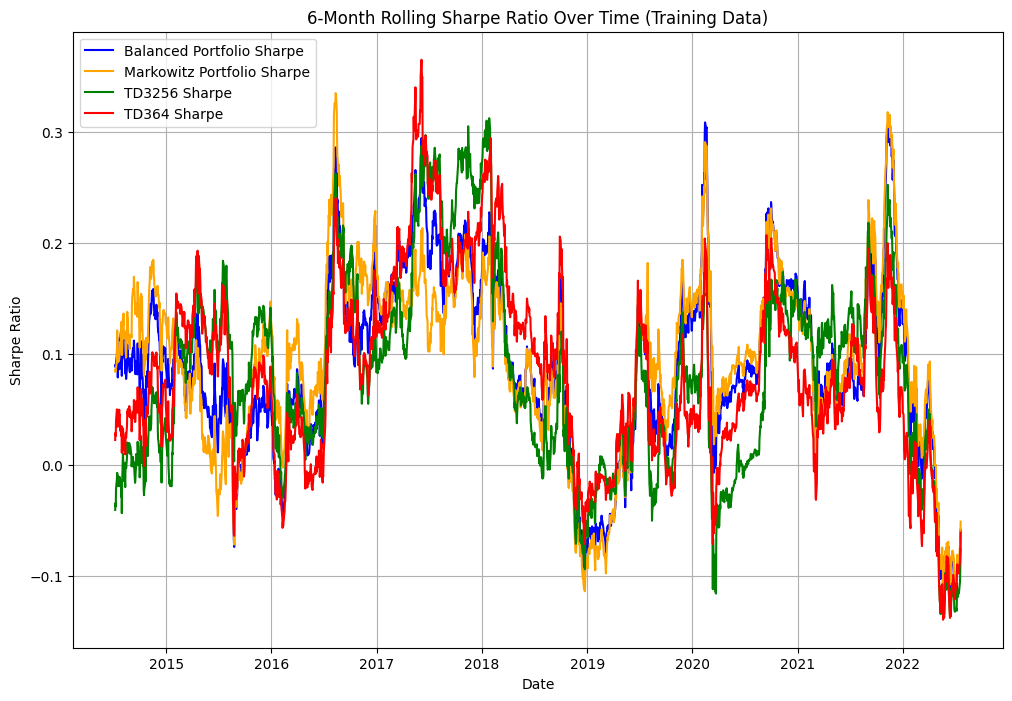

In [37]:
# Plotting Sharpe Ratios
plt.figure(figsize=(12, 8))
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['balanced_portfolio']), label='Balanced Portfolio Sharpe', color='blue')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['markowitz']), label='Markowitz Portfolio Sharpe', color='orange')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['TD3256']), label='TD3256 Sharpe', color='green')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['TD364']), label='TD364 Sharpe', color='red')

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('6-Month Rolling Sharpe Ratio Over Time (Training Data)')
plt.legend()
plt.grid(True)
plt.show()


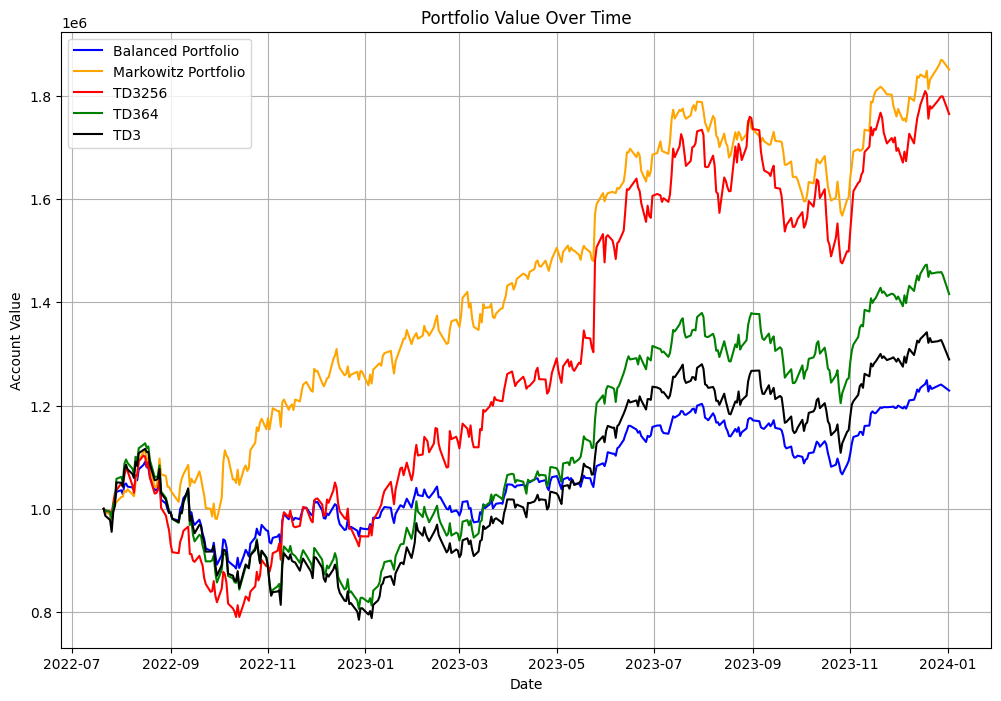

In [38]:
test_results = portfolio_balance_test
test_results['markowitz']=markowitz_balance_test['portfolio_value']
test_results['TD3256']=TD3256_test['account_value']    
test_results['TD364']=TD364_test['account_value']    


# Plotting
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], test_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(test_results['date'], test_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(test_results['date'], test_results['TD3256'], label='TD3256', color='red')
plt.plot(test_results['date'], test_results['TD364'], label='TD364', color='green')
plt.plot(test_results['date'], test_results['TD3'], label='TD3', color='black')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

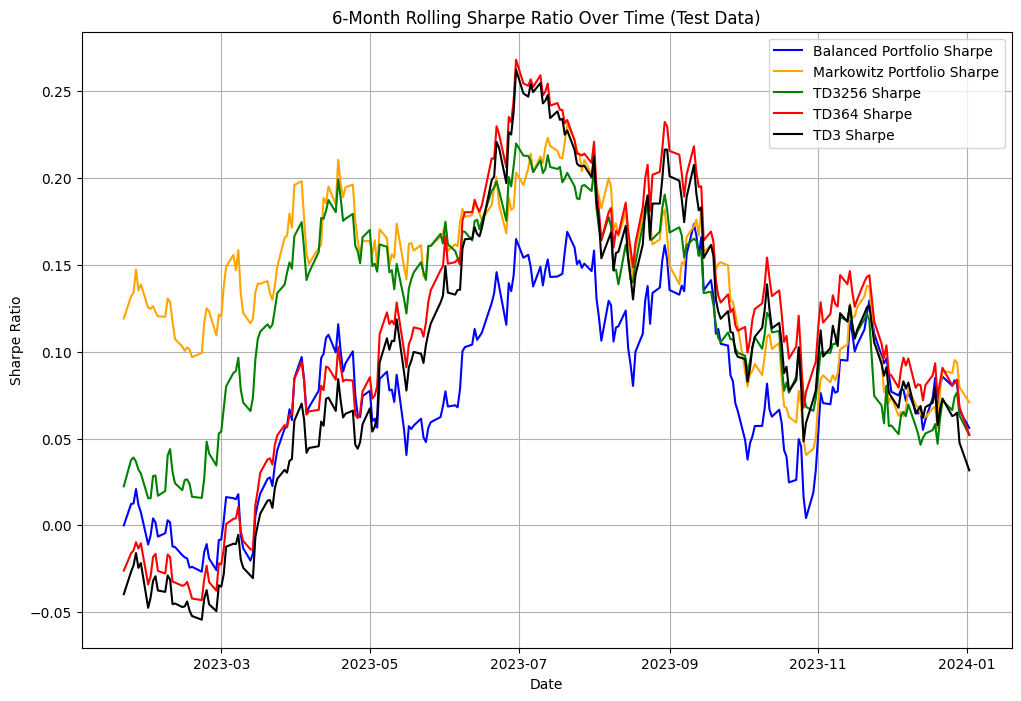

In [39]:
# Plotting Sharpe Ratios
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], calculate_sharpe(test_results['balanced_portfolio']), label='Balanced Portfolio Sharpe', color='blue')
plt.plot(test_results['date'], calculate_sharpe(test_results['markowitz']), label='Markowitz Portfolio Sharpe', color='orange')
plt.plot(test_results['date'], calculate_sharpe(test_results['TD3256']), label='TD3256 Sharpe', color='green')
plt.plot(test_results['date'], calculate_sharpe(test_results['TD364']), label='TD364 Sharpe', color='red')
plt.plot(test_results['date'], calculate_sharpe(test_results['TD3']), label='TD3 Sharpe', color='black')

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('6-Month Rolling Sharpe Ratio Over Time (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

## Evaluating different learning rates

In [40]:
policy_kwargs = dict(
    net_arch=[256, 256],  
    activation_fn=torch.nn.ReLU  
)
# Training the models with different learning rates
lr001_model, lr001_train, lr001_train_actions = run_model_w_arg_and_evaluate(TD3, "MlpPolicy", train_p_df, env_kwargs, policy_kwargs, 50000, 0.001)
lr0005_model, lr0005_train, lr0005_train_actions = run_model_w_arg_and_evaluate(TD3, "MlpPolicy", train_p_df, env_kwargs, policy_kwargs, 50000, 0.0005)
lr0001_model, lr0001_train, lr0001_train_actions = run_model_w_arg_and_evaluate(TD3, "MlpPolicy", train_p_df, env_kwargs, policy_kwargs, 50000, 0.0001)

# Evaluating the trained models on the test dataset
lr001_test, lr001_test_actions = evaluate_model(lr001_model, test_p_df, env_kwargs)
lr0005_test, lr0005_test_actions = evaluate_model(lr0005_model, test_p_df, env_kwargs)
lr0001_test, lr0001_test_actions = evaluate_model(lr0001_model, test_p_df, env_kwargs)


Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 76        |
|    time_elapsed    | 111       |
|    total_timesteps | 8600      |
| train/             |           |
|    actor_loss      | -5.65e+07 |
|    critic_loss     | 5.87e+13  |
|    learning_rate   | 0.001     |
|    n_updates       | 6450      |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 74        |
|    time_elapsed    | 232       |
|    total_timesteps | 17200     |
| train/             |           |
|    actor_loss      | -2.96e+07 |
|    critic_loss     | 4.49e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 15050     |
----------------------------------
day: 2149, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 6386400.75
total_reward: 5386400.75
total_cost: 1291.68
total_trades: 28

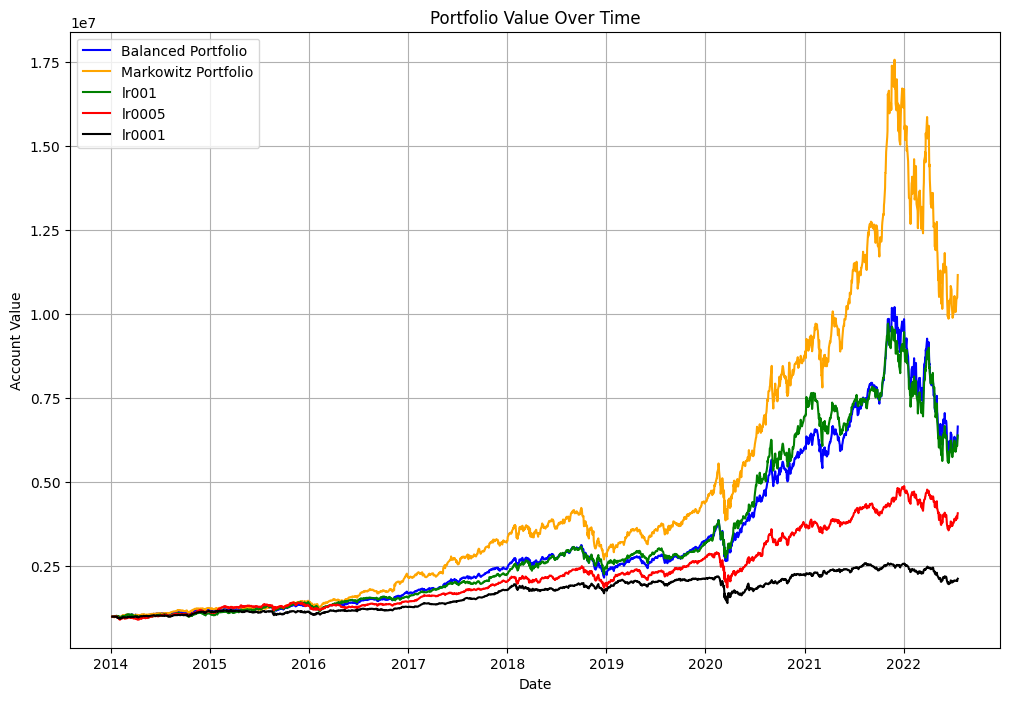

In [41]:
trainning_results = portfolio_balance_train
trainning_results['markowitz']=markowitz_balance_train['portfolio_value']
trainning_results['lr001']=lr001_train['account_value']    
trainning_results['lr0005']=lr0005_train['account_value']    
trainning_results['lr0001']=lr0001_train['account_value']    


# Plotting
plt.figure(figsize=(12, 8))
plt.plot(trainning_results['date'], trainning_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(trainning_results['date'], trainning_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(trainning_results['date'], trainning_results['lr001'], label='lr001', color='green')
plt.plot(trainning_results['date'], trainning_results['lr0005'], label='lr0005', color='red')
plt.plot(trainning_results['date'], trainning_results['lr0001'], label='lr0001', color='black')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

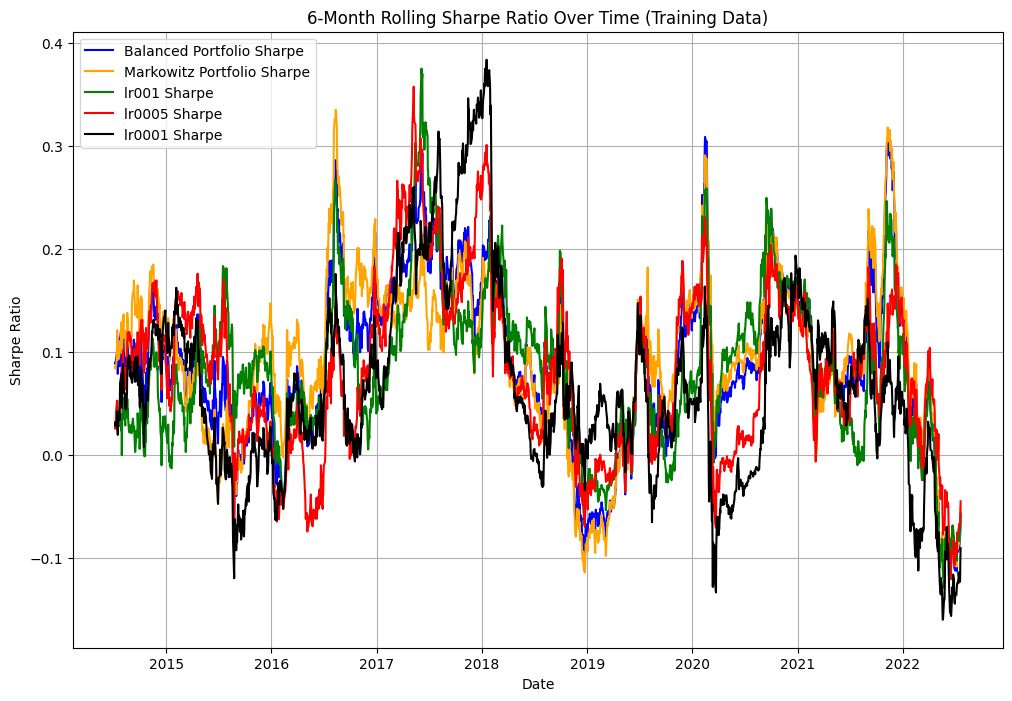

In [42]:
# Plotting Sharpe Ratios
plt.figure(figsize=(12, 8))
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['balanced_portfolio']), label='Balanced Portfolio Sharpe', color='blue')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['markowitz']), label='Markowitz Portfolio Sharpe', color='orange')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['lr001']), label='lr001 Sharpe', color='green')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['lr0005']), label='lr0005 Sharpe', color='red')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['lr0001']), label='lr0001 Sharpe', color='black')

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('6-Month Rolling Sharpe Ratio Over Time (Training Data)')
plt.legend()
plt.grid(True)
plt.show()


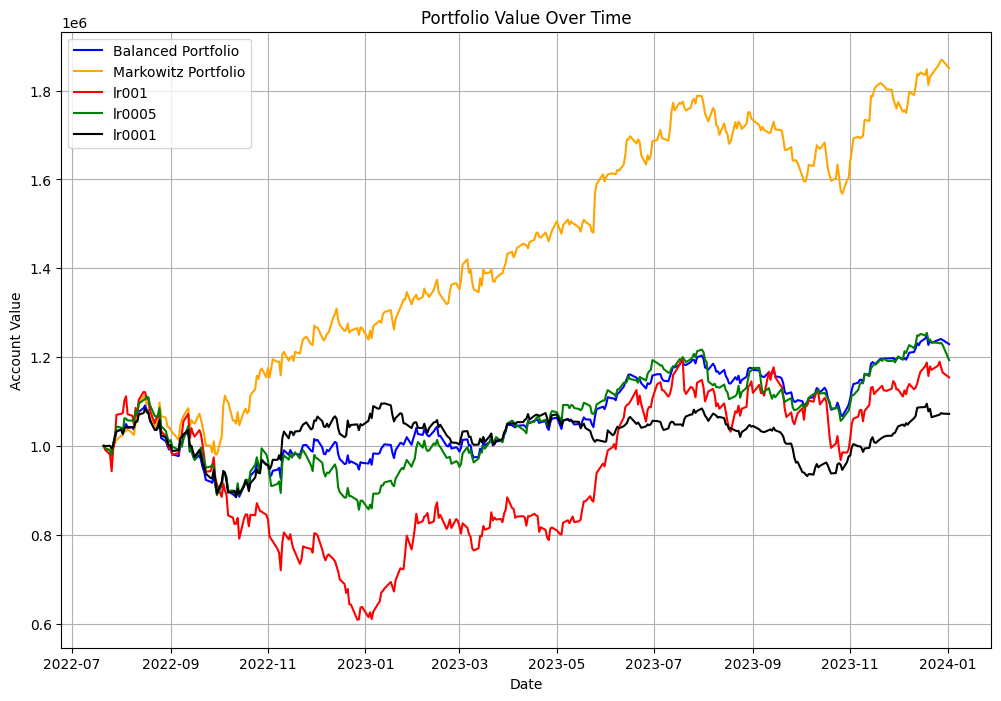

In [43]:
test_results = portfolio_balance_test
test_results['markowitz']=markowitz_balance_test['portfolio_value']
test_results['lr001']=lr001_test['account_value']    
test_results['lr0005']=lr0005_test['account_value']    
test_results['lr0001']=lr0001_test['account_value']    

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], test_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(test_results['date'], test_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(test_results['date'], test_results['lr001'], label='lr001', color='red')
plt.plot(test_results['date'], test_results['lr0005'], label='lr0005', color='green')
plt.plot(test_results['date'], test_results['lr0001'], label='lr0001', color='black')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

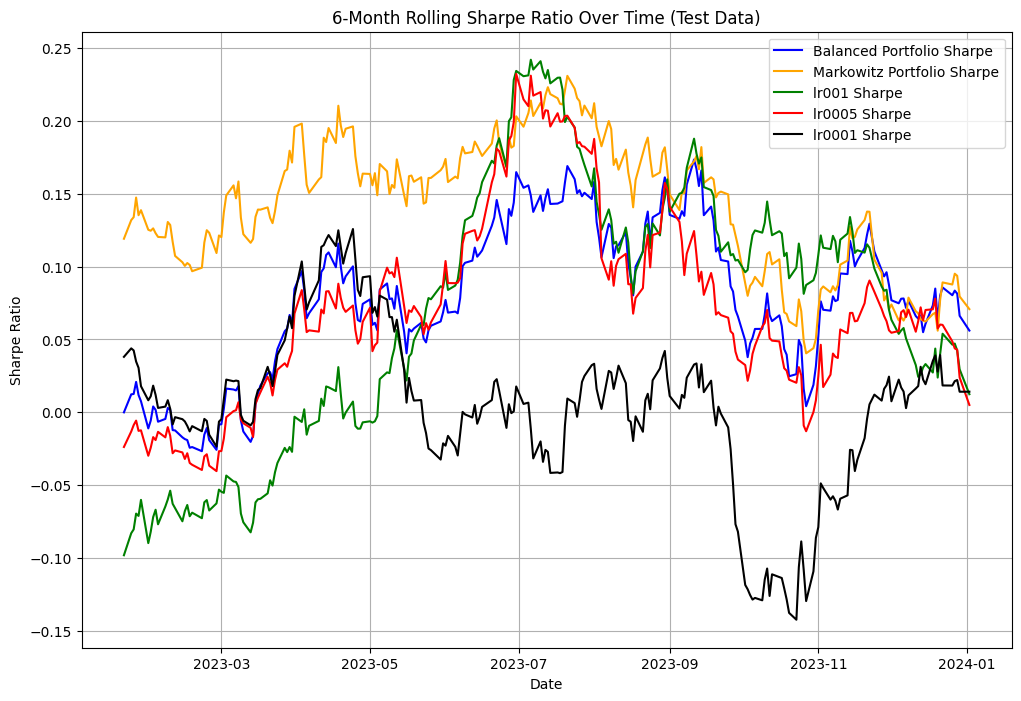

In [44]:
# Plotting Sharpe Ratios
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], calculate_sharpe(test_results['balanced_portfolio']), label='Balanced Portfolio Sharpe', color='blue')
plt.plot(test_results['date'], calculate_sharpe(test_results['markowitz']), label='Markowitz Portfolio Sharpe', color='orange')
plt.plot(test_results['date'], calculate_sharpe(test_results['lr001']), label='lr001 Sharpe', color='green')
plt.plot(test_results['date'], calculate_sharpe(test_results['lr0005']), label='lr0005 Sharpe', color='red')
plt.plot(test_results['date'], calculate_sharpe(test_results['lr0001']), label='lr0001 Sharpe', color='black')

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('6-Month Rolling Sharpe Ratio Over Time (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

## Evaluating different timesteps lengths

In [49]:
learning_rate= 0.005
policy_kwargs = dict(
    net_arch=[256, 256],  
    activation_fn=torch.nn.ReLU  
) 
# Training the models with different learning rates
ts10k_model, ts10k_train, ts10k_train_actions = run_model_w_arg_and_evaluate(DDPG, "MlpPolicy", train_p_df, env_kwargs, policy_kwargs, 10000, 0.0005)
ts50k_model, ts50k_train, ts50k_train_actions = run_model_w_arg_and_evaluate(DDPG, "MlpPolicy", train_p_df, env_kwargs, policy_kwargs, 50000, 0.0005)
ts100k_model, ts100k_train, ts100k_train_actions = run_model_w_arg_and_evaluate(DDPG, "MlpPolicy", train_p_df, env_kwargs, policy_kwargs, 100000, 0.0005)

# Evaluating the trained models on the test dataset
ts10k_test, ts10k_test_actions = evaluate_model(ts10k_model, test_p_df, env_kwargs)
ts50k_test, ts50k_test_actions = evaluate_model(ts50k_model, test_p_df, env_kwargs)
ts100k_test, ts100k_test_actions = evaluate_model(ts100k_model, test_p_df, env_kwargs)



Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 78        |
|    time_elapsed    | 110       |
|    total_timesteps | 8600      |
| train/             |           |
|    actor_loss      | -3.28e+08 |
|    critic_loss     | 6.29e+13  |
|    learning_rate   | 0.0005    |
|    n_updates       | 6450      |
----------------------------------
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 75       |
|    time_elapsed    | 113      |
|    total_timesteps | 8600     |
| train/             |          |
|    actor_loss      | 2.52e+08 |
|    critic_loss     | 5.12e+13 |
|    learning_rate   | 0.0005   |
|    n_updates       | 6450     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 72       |


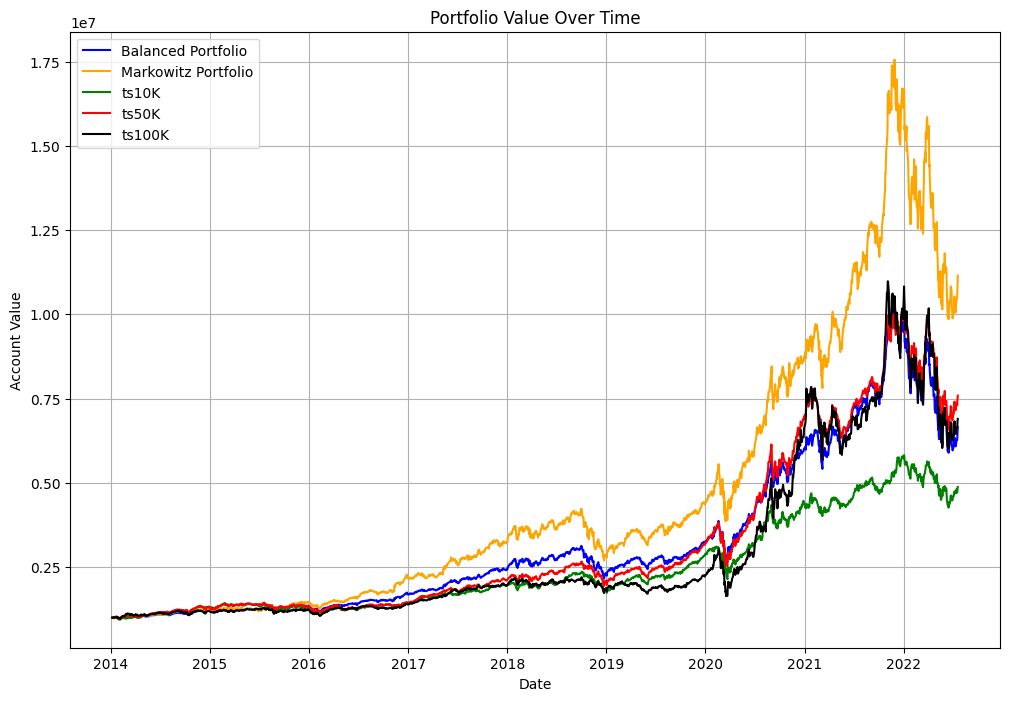

In [50]:
trainning_results = portfolio_balance_train
trainning_results['markowitz']=markowitz_balance_train['portfolio_value']
trainning_results['ts10K']=ts10k_train['account_value']
trainning_results['ts50K']=ts50k_train['account_value']    
trainning_results['ts100K']=ts100k_train['account_value']    

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(trainning_results['date'], trainning_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(trainning_results['date'], trainning_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(trainning_results['date'], trainning_results['ts10K'], label='ts10K', color='green')
plt.plot(trainning_results['date'], trainning_results['ts50K'], label='ts50K', color='red')
plt.plot(trainning_results['date'], trainning_results['ts100K'], label='ts100K', color='black')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

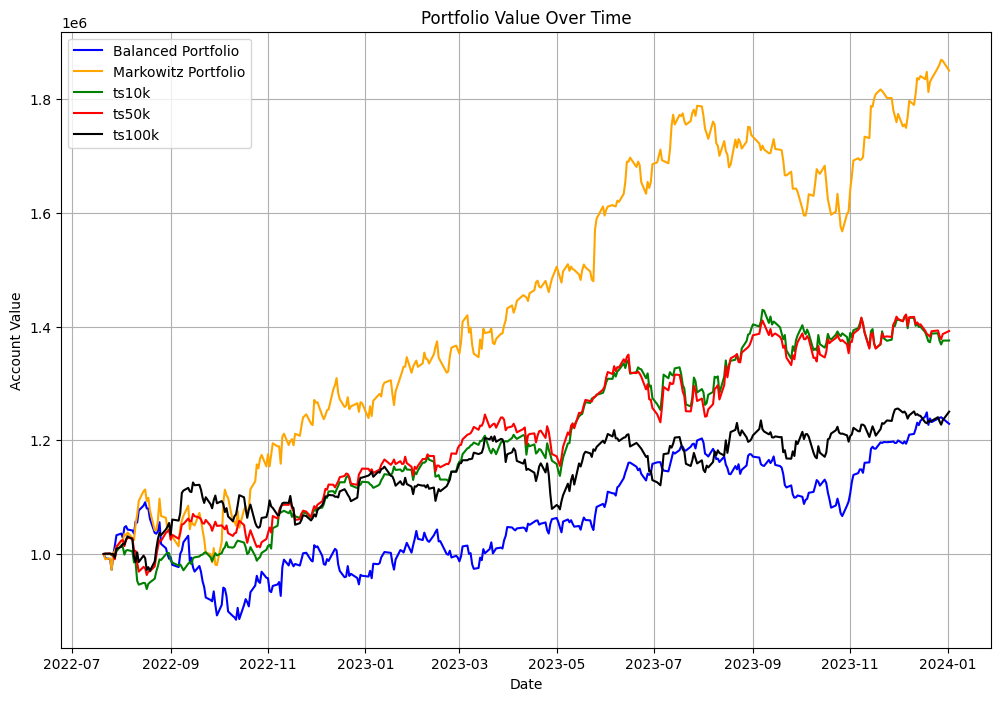

In [51]:
test_results = portfolio_balance_test
test_results['markowitz']=markowitz_balance_test['portfolio_value']
test_results['ts10k']=ts10k_train['account_value']
test_results['ts50k']=ts50k_train['account_value']    
test_results['ts100k']=ts100k_train['account_value']    


# Plotting
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], test_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(test_results['date'], test_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(test_results['date'], test_results['ts10k'], label='ts10k', color='green')
plt.plot(test_results['date'], test_results['ts50k'], label='ts50k', color='red')
plt.plot(test_results['date'], test_results['ts100k'], label='ts100k', color='black')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

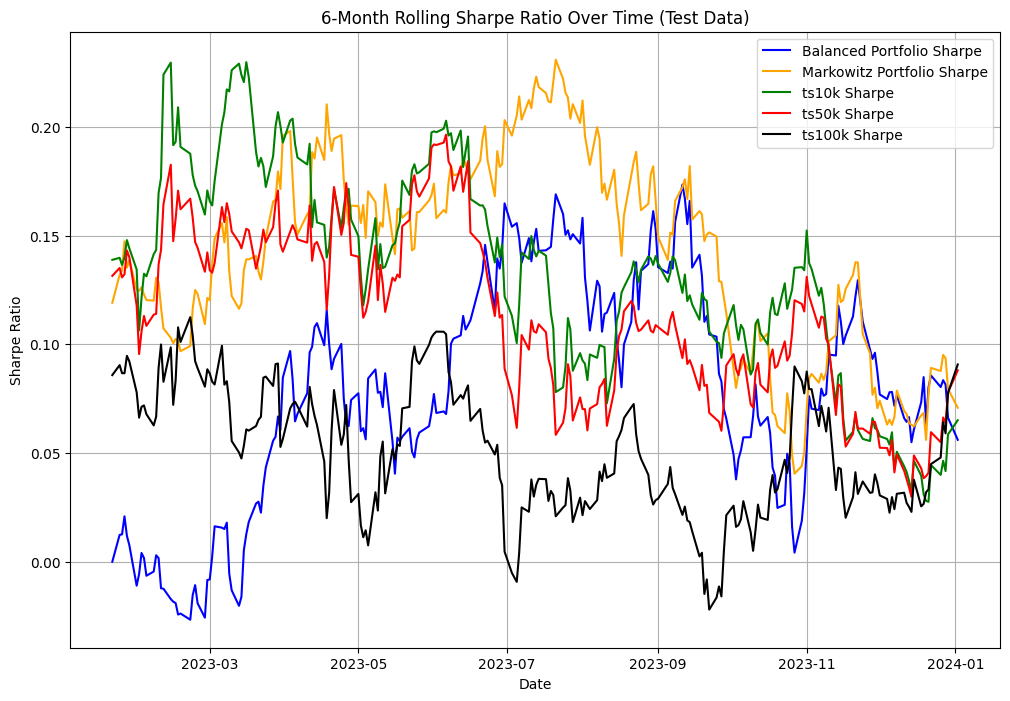

In [52]:
# Plotting Sharpe Ratios
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], calculate_sharpe(test_results['balanced_portfolio']), label='Balanced Portfolio Sharpe', color='blue')
plt.plot(test_results['date'], calculate_sharpe(test_results['markowitz']), label='Markowitz Portfolio Sharpe', color='orange')
plt.plot(test_results['date'], calculate_sharpe(test_results['ts10k']), label='ts10k Sharpe', color='green')
plt.plot(test_results['date'], calculate_sharpe(test_results['ts50k']), label='ts50k Sharpe', color='red')
plt.plot(test_results['date'], calculate_sharpe(test_results['ts100k']), label='ts100k Sharpe', color='black')

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('6-Month Rolling Sharpe Ratio Over Time (Test Data)')
plt.legend()
plt.grid(True)
plt.show()


# Evalutation of PCA on performance

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Function to apply PCA transformation
def apply_pca_to_df(df, columns_for_pca, scaler, pca):
    # Normalizing the selected columns
    normalized_features = scaler.transform(df[columns_for_pca])

    # Applying PCA
    pca_features = pca.transform(normalized_features)

    # Creating a new DataFrame with PCA features
    pca_columns = [f'pca_{i+1}' for i in range(pca_features.shape[1])]
    pca_df = pd.DataFrame(pca_features, columns=pca_columns)

    # Combining PCA DataFrame with the rest of the data
    excluded_columns = df[['date', 'tic', 'open', 'high', 'low', 'close', 'turbulence']]
    final_df = pd.concat([excluded_columns.reset_index(drop=True), pca_df], axis=1)

    return final_df

# Selecting columns for PCA
columns_for_pca = [col for col in train_p_df.columns if col not in ['date', 'tic', 'open', 'high', 'low', 'close', 'turbulence']]

# Normalizing the selected columns
scaler = StandardScaler()
scaler.fit(train_p_df[columns_for_pca])  # Fit only on training data

# Applying PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
pca.fit(scaler.transform(train_p_df[columns_for_pca]))  # Fit only on training data

# Transforming both datasets
train_p_df_pca = apply_pca_to_df(train_p_df, columns_for_pca, scaler, pca)
test_p_df_pca = apply_pca_to_df(test_p_df, columns_for_pca, scaler, pca)



In [54]:
# Function to reset indexes and concatenate for each DataFrame
def reset_and_concat(df):
    grouped_dfs = []
    for tic, group_df in df.groupby('tic'):
        reset_group_df = group_df.reset_index(drop=True)
        grouped_dfs.append(reset_group_df)
    result_df = pd.concat(grouped_dfs, axis=0)
    result_df = result_df.sort_values(by=['date', 'tic'])

    return result_df

# Reset indexes for 'train_p_df_pca'
train_p_df_pca = reset_and_concat(train_p_df_pca)

# Reset indexes for 'test_p_df_pca'
test_p_df_pca = reset_and_concat(test_p_df_pca)



In [55]:
INDICATORS = [
    'turbulence',
    'pca_1',
    'pca_2', 
    'pca_3', 
    'pca_4', 
    'pca_5', 
    'pca_6', 
    'pca_7', 
    'pca_8', 
    'pca_9',
    'pca_10', 
    'pca_11', 
    'pca_12', 
    'pca_13', 
    'pca_14', 
    'pca_15'
]
  

stock_dimension = len(train_p_df_pca.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
  
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train_p_df_pca, **env_kwargs)


Stock Dimension: 19, State Space: 343


In [57]:
pca_model, pca_train, pca_train_actions = run_model_w_arg_and_evaluate(TD3, "MlpPolicy", train_p_df_pca, env_kwargs, policy_kwargs, 50000, 0.0005)

pca_test, pca_test_actions = evaluate_model(pca_model, test_p_df, env_kwargs)


Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 91       |
|    time_elapsed    | 94       |
|    total_timesteps | 8600     |
| train/             |          |
|    actor_loss      | -40      |
|    critic_loss     | 573      |
|    learning_rate   | 0.0005   |
|    n_updates       | 6450     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 87       |
|    time_elapsed    | 196      |
|    total_timesteps | 17200    |
| train/             |          |
|    actor_loss      | -1.9     |
|    critic_loss     | 77.8     |
|    learning_rate   | 0.0005   |
|    n_updates       | 15050    |
---------------------------------
day: 2149, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 10276217.95
total_reward: 9276217.95
total_cost: 999.00
total_trades: 15043
Sharpe: 0.957
------

KeyError: 'pca_1'

In [58]:
pca_test, pca_test_actions = evaluate_model(pca_model, test_p_df_pca, env_kwargs)




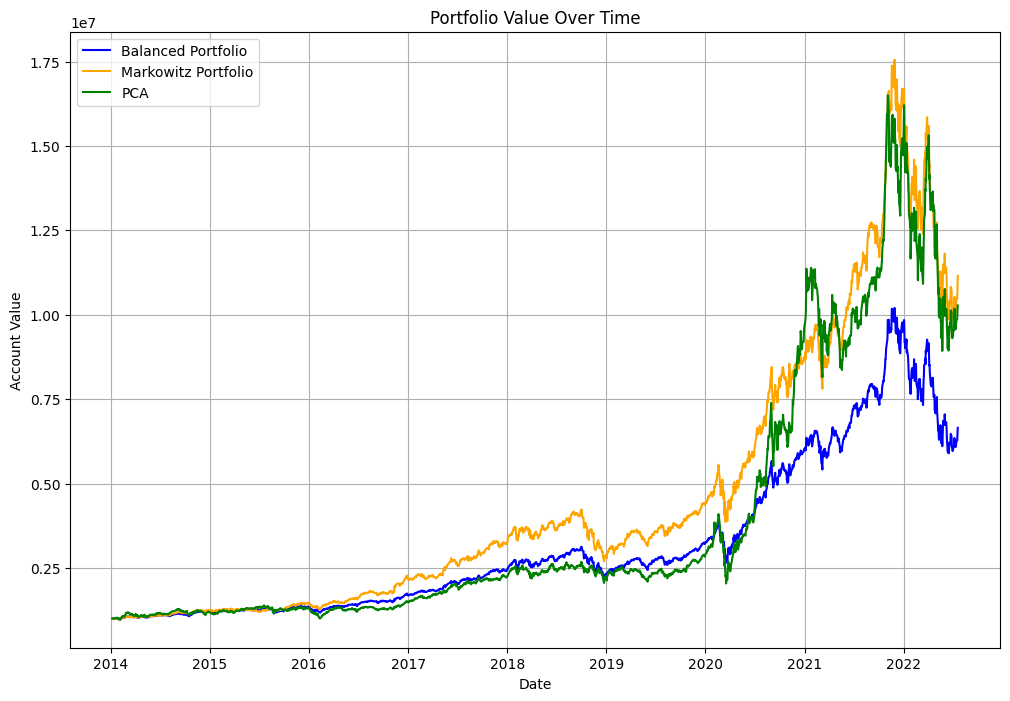

In [59]:
trainning_results = portfolio_balance_train
trainning_results['markowitz']= markowitz_balance_train['portfolio_value']
trainning_results['PCA']= pca_train['account_value']    


# Plotting
plt.figure(figsize=(12, 8))
plt.plot(trainning_results['date'], trainning_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(trainning_results['date'], trainning_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(trainning_results['date'], trainning_results['PCA'], label='PCA', color='green')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

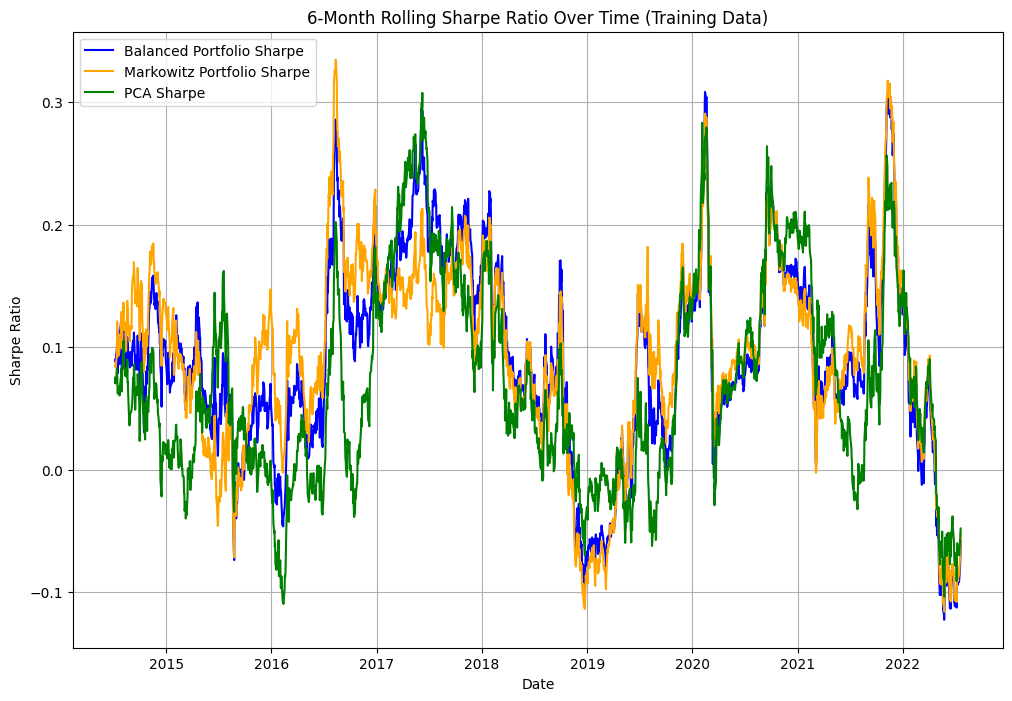

In [60]:
# Plotting Sharpe Ratios
plt.figure(figsize=(12, 8))
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['balanced_portfolio']), label='Balanced Portfolio Sharpe', color='blue')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['markowitz']), label='Markowitz Portfolio Sharpe', color='orange')
plt.plot(trainning_results['date'], calculate_sharpe(trainning_results['PCA']), label='PCA Sharpe', color='green')

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('6-Month Rolling Sharpe Ratio Over Time (Training Data)')
plt.legend()
plt.grid(True)
plt.show()


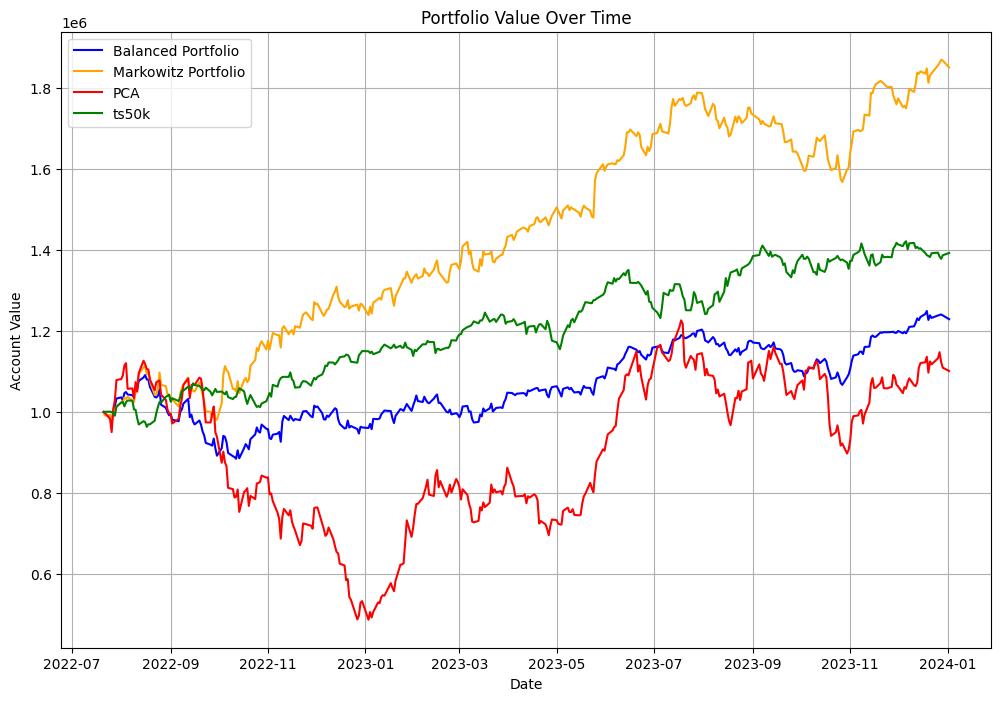

In [68]:
test_results = portfolio_balance_test
test_results['markowitz']=markowitz_balance_test['portfolio_value']
test_results['PCA']=pca_test['account_value']    

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], test_results['balanced_portfolio'], label='Balanced Portfolio', color='blue')
plt.plot(test_results['date'], test_results['markowitz'], label='Markowitz Portfolio', color='orange')
plt.plot(test_results['date'], test_results['PCA'], label='PCA', color='red')
plt.plot(test_results['date'], test_results['ts50k'], label='ts50k', color='green')

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

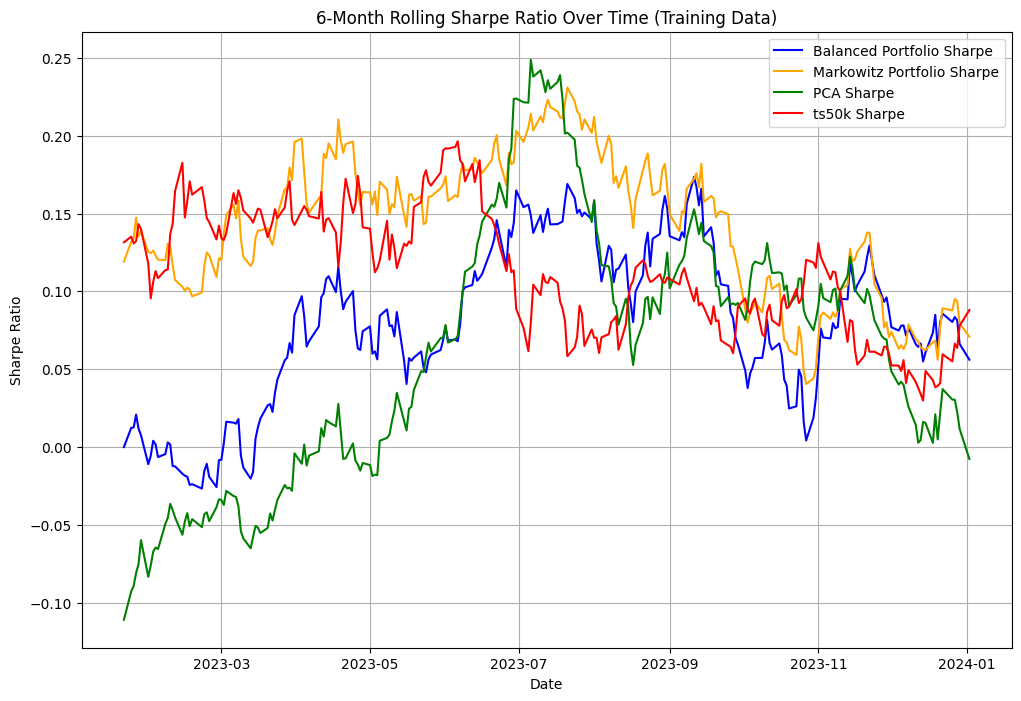

In [69]:
# Plotting Sharpe Ratios
plt.figure(figsize=(12, 8))
plt.plot(test_results['date'], calculate_sharpe(test_results['balanced_portfolio']), label='Balanced Portfolio Sharpe', color='blue')
plt.plot(test_results['date'], calculate_sharpe(test_results['markowitz']), label='Markowitz Portfolio Sharpe', color='orange')
plt.plot(test_results['date'], calculate_sharpe(test_results['PCA']), label='PCA Sharpe', color='green')
plt.plot(test_results['date'], calculate_sharpe(test_results['ts50k']), label='ts50k Sharpe', color='red')


plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('6-Month Rolling Sharpe Ratio Over Time (Training Data)')
plt.legend()
plt.grid(True)
plt.show()


# Final Results


In [63]:
test_results

,date,balanced_portfolio,markowitz,A2C,PPO,SAC,TD3,DDPG,TD3256,TD364,lr001,lr0005,lr0001,ts10k,ts50k,ts100k,PCA
0,2022-07-21,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
1,2022-07-22,9.928001e+05,9.907675e+05,9.935164e+05,9.981295e+05,9.897144e+05,9.866814e+05,9.901879e+05,9.969152e+05,9.973121e+05,9.913165e+05,9.948256e+05,9.994451e+05,9.997583e+05,1.000294e+06,1.000759e+06,9.963879e+05
2,2022-07-25,9.907845e+05,9.924521e+05,9.811075e+05,9.956543e+05,9.816632e+05,9.784665e+05,9.827678e+05,9.949474e+05,9.939312e+05,9.800618e+05,9.894627e+05,1.000217e+06,9.999866e+05,1.000759e+06,1.000772e+06,9.828755e+05
3,2022-07-26,9.723808e+05,9.718928e+05,9.468803e+05,9.851898e+05,9.562166e+05,9.554709e+05,9.535820e+05,9.876975e+05,9.812270e+05,9.430003e+05,9.789508e+05,9.940338e+05,9.979338e+05,9.994060e+05,1.000095e+06,9.502736e+05
4,2022-07-27,9.978942e+05,1.000941e+06,9.966066e+05,1.006748e+06,9.928376e+05,9.942288e+05,9.932863e+05,1.011641e+06,1.007444e+06,9.937434e+05,1.007367e+06,1.001643e+06,9.965884e+05,9.972825e+05,9.998659e+05,1.007494e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023-12-26,1.238066e+06,1.855493e+06,1.319798e+06,1.258028e+06,1.242117e+06,1.324429e+06,1.240675e+06,1.790279e+06,1.457971e+06,1.180555e+06,1.231972e+06,1.069138e+06,1.388298e+06,1.393158e+06,1.240652e+06,1.132403e+06
361,2023-12-27,1.239509e+06,1.861507e+06,1.329120e+06,1.258043e+06,1.241938e+06,1.325746e+06,1.240097e+06,1.794738e+06,1.457559e+06,1.189608e+06,1.230623e+06,1.070217e+06,1.375167e+06,1.383470e+06,1.233125e+06,1.147432e+06
362,2023-12-28,1.240568e+06,1.869461e+06,1.316046e+06,1.259382e+06,1.243754e+06,1.326773e+06,1.241716e+06,1.798520e+06,1.458568e+06,1.176164e+06,1.232224e+06,1.073733e+06,1.368574e+06,1.377924e+06,1.227494e+06,1.123222e+06
363,2023-12-29,1.238228e+06,1.867531e+06,1.306222e+06,1.251295e+06,1.237734e+06,1.320078e+06,1.234288e+06,1.798196e+06,1.453061e+06,1.164984e+06,1.226782e+06,1.072651e+06,1.375342e+06,1.386884e+06,1.235288e+06,1.109303e+06


In [64]:
# Initialize a dictionary to store cumulative returns for each model
cumulative_returns = {}

# Calculate cumulative returns for each model
initial_investment = 1000000  # Initial investment for each model

for col in test_results.columns:
    if col != "date":
        returns = (test_results[col] / 1000000)  # Calculate daily returns
        cumulative_returns[col] = returns  # Store cumulative returns

# Create a new DataFrame to store cumulative returns
cumulative_returns_df = pd.DataFrame(cumulative_returns)

# Print the cumulative returns for each model
cumulative_returns_df


,balanced_portfolio,markowitz,A2C,PPO,SAC,TD3,DDPG,TD3256,TD364,lr001,lr0005,lr0001,ts10k,ts50k,ts100k,PCA
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992800,0.990767,0.993516,0.998129,0.989714,0.986681,0.990188,0.996915,0.997312,0.991317,0.994826,0.999445,0.999758,1.000294,1.000759,0.996388
2,0.990784,0.992452,0.981108,0.995654,0.981663,0.978467,0.982768,0.994947,0.993931,0.980062,0.989463,1.000217,0.999987,1.000759,1.000772,0.982876
3,0.972381,0.971893,0.946880,0.985190,0.956217,0.955471,0.953582,0.987697,0.981227,0.943000,0.978951,0.994034,0.997934,0.999406,1.000095,0.950274
4,0.997894,1.000941,0.996607,1.006748,0.992838,0.994229,0.993286,1.011641,1.007444,0.993743,1.007367,1.001643,0.996588,0.997282,0.999866,1.007494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1.238066,1.855493,1.319798,1.258028,1.242117,1.324429,1.240675,1.790279,1.457971,1.180555,1.231972,1.069138,1.388298,1.393158,1.240652,1.132403
361,1.239509,1.861507,1.329120,1.258043,1.241938,1.325746,1.240097,1.794738,1.457559,1.189608,1.230623,1.070217,1.375167,1.383470,1.233125,1.147432
362,1.240568,1.869461,1.316046,1.259382,1.243754,1.326773,1.241716,1.798520,1.458568,1.176164,1.232224,1.073733,1.368574,1.377924,1.227494,1.123222
363,1.238228,1.867531,1.306222,1.251295,1.237734,1.320078,1.234288,1.798196,1.453061,1.164984,1.226782,1.072651,1.375342,1.386884,1.235288,1.109303


In [65]:
# Accessing the last row of the DataFrame to get the final cumulative returns
final_cumulative_returns = cumulative_returns_df.iloc[-1]

# Displaying the final cumulative returns for each model
final_cumulative_returns


balanced_portfolio    1.229023
markowitz             1.850331
A2C                   1.289004
PPO                   1.218353
SAC                   1.209903
TD3                   1.289156
DDPG                  1.207175
TD3256                1.764294
TD364                 1.415760
lr001                 1.154250
lr0005                1.192934
lr0001                1.072022
ts10k                 1.375538
ts50k                 1.392239
ts100k                1.250404
PCA                   1.100992
Name: 364, dtype: float64

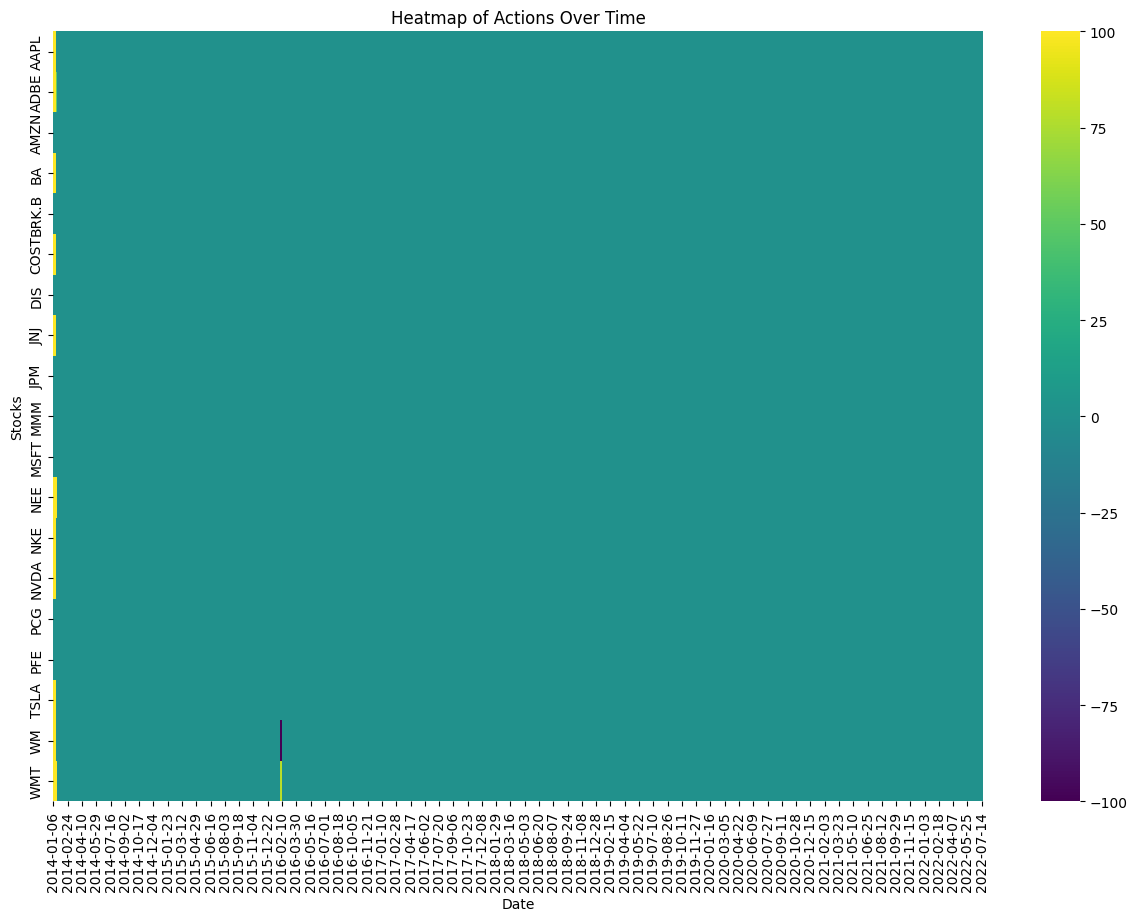

In [70]:
# Seaborn heatmap to show a view of the actions that the model took.

plt.figure(figsize=(15, 10))
sns.heatmap(ts50k_train_actions.T, cmap='viridis')
plt.xlabel('Date')
plt.ylabel('Stocks')
plt.title('Heatmap of Actions Over Time')
plt.show()


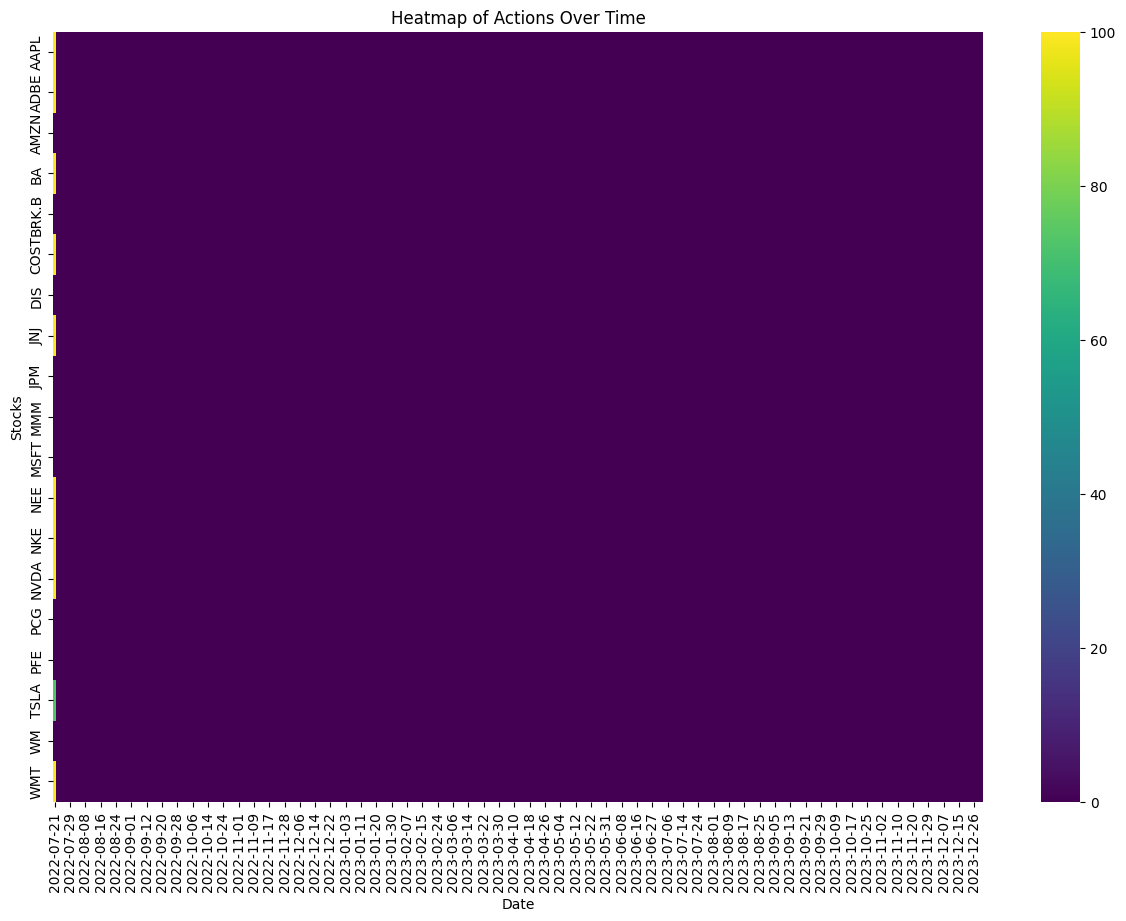

In [72]:
plt.figure(figsize=(15, 10))
sns.heatmap(ts50k_test_actions.T, cmap='viridis')
plt.xlabel('Date')
plt.ylabel('Stocks')
plt.title('Heatmap of Actions Over Time')
plt.show()
